In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
def linear(p,x):
    return p[0]*x + p[1]

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

In [3]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:", error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

## Data

In [4]:
initial = pd.read_csv('./data/calibration_2i.csv')
final = pd.read_csv('./data/calibration_2f.csv')

In [5]:
channel_i = initial['centroid'] / (initial['fine_gain'] * initial['gain'])
channel_f = final['centroid'] / (final['fine_gain'] * final['gain'])

# Fit

In [6]:
model = linear

params_i = [1, 0]

params_f0, params_err0, chisq0, dof0 = data_fit(
    params_i, 
    model, 
    channel_i, initial['energy'], initial['energy_err']
)

params_f1, params_err1, chisq1, dof1 = data_fit(
    params_i, 
    model, 
    channel_f, final['energy'], final['energy_err']
)


Converged with chi-squared 45313.30
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 5664.16

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+00                | 1.538e+00                | 1.283e-03               
1           | 0.000e+00                | -4.155e+00               | 4.235e-01               

Converged with chi-squared 776.68
Number of degrees of freedom, dof = 5.00
Reduced chi-squared 155.34

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+00                | 1.496e+00                | 1.355e-03               
1           | 0.000e+00                | -7.441e+00               | 5.419e-01               


# Plot

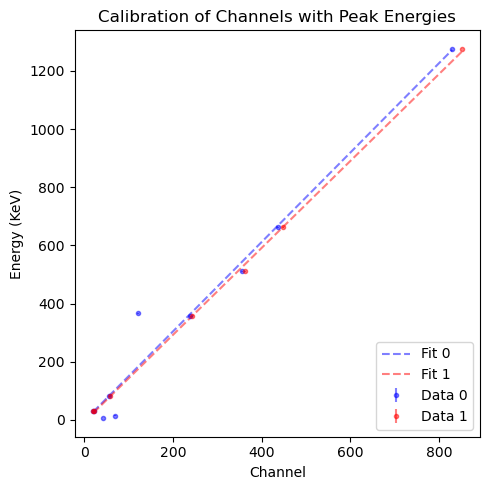

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.errorbar(
    x=channel_i, 
    y=initial['energy'], yerr=initial['energy_err'], 
    fmt='b.', alpha=0.5, label='Data 0'       
)
linspace0 = np.linspace(channel_i.min(), channel_i.max(), 100)
ax.plot(linspace0, model(params_f0, linspace0), color='b', linestyle='dashed', alpha=0.5, label='Fit 0')

ax.errorbar(
    x=channel_f, 
    y=final['energy'], yerr=final['energy_err'], 
    fmt='r.', alpha=0.5, label='Data 1'       
)
linspace1 = np.linspace(channel_f.min(), channel_f.max(), 100)
ax.plot(linspace1, model(params_f1, linspace1), color='r', linestyle='dashed', alpha=0.5, label='Fit 1')


ax.set_xlabel('Channel')
ax.set_ylabel('Energy (KeV)')
ax.set_title('Calibration of Channels with Peak Energies')
ax.legend(loc='lower right')

plt.tight_layout()